In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

Using TensorFlow backend.
/home/mlvm2/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [93]:
data = pd.read_csv('bitcoin_hourly.csv', index_col="Timestamp")

data.tail()

,Close,Volume (Currency)
Timestamp,,
20/05/2018 15:00,8377.20,1458258.14
20/05/2018 16:00,8481.11,7638432.56
20/05/2018 17:00,8516.36,1890285.06
20/05/2018 18:00,8524.00,970082.61
20/05/2018 19:00,8504.00,597328.06


In [94]:
#Tranform the date field

data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               ...
               '2018-05-20 10:00:00', '2018-05-20 11:00:00',
               '2018-05-20 12:00:00', '2018-05-20 13:00:00',
               '2018-05-20 14:00:00', '2018-05-20 15:00:00',
               '2018-05-20 16:00:00', '2018-05-20 17:00:00',
               '2018-05-20 18:00:00', '2018-05-20 19:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=4316, freq=None)


,Close,Volume (Currency)
Timestamp,,
2017-11-22 00:00:00,8121.18,2363051.72
2017-11-22 01:00:00,8164.99,1064864.49
2017-11-22 02:00:00,8177.43,1279067.60
2017-11-22 03:00:00,8161.66,1084826.00
2017-11-22 04:00:00,8168.17,2079548.30


Text(0,0.5,'Daily Bitcoin price')

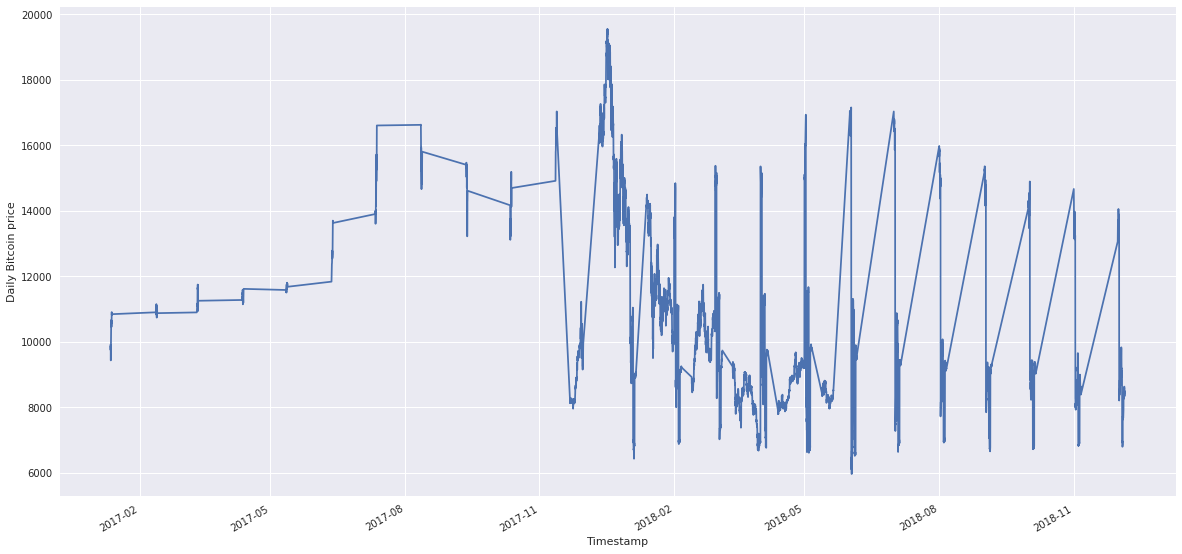

In [95]:
data['Close'].plot(figsize=(20,10))
plt.ylabel("Daily Bitcoin price")

Timestamp
1    AxesSubplot(0.125,0.2;0.775x0.68)
2    AxesSubplot(0.125,0.2;0.775x0.68)
3    AxesSubplot(0.125,0.2;0.775x0.68)
4    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Close, dtype: object

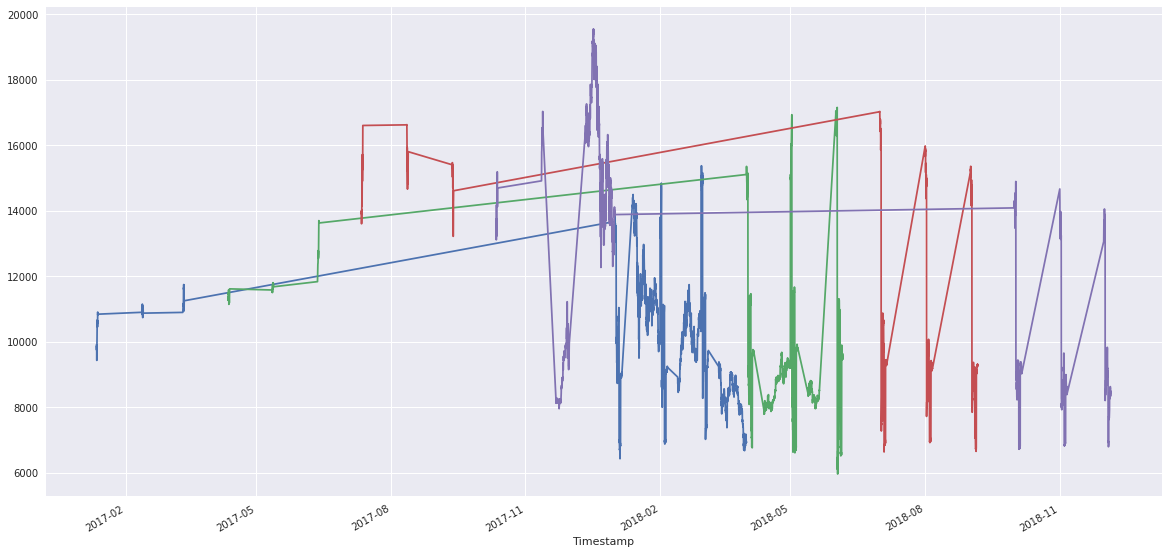

In [96]:
data1 = data['Close']

by_quarter = data1.groupby(data1.index.quarter)
by_quarter.plot(figsize=(20,10))

In [97]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [100]:
# load dataset
dataset1 = data[['Close','Volume (Currency)']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
lag_hour = 3
reframed = series_to_supervised(scaled, lag_hour, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.158921   0.027551   0.162146   0.010725   0.163061   0.013501  0.161901
4   0.162146   0.010725   0.163061   0.013501   0.161901   0.010984  0.162380
5   0.163061   0.013501   0.161901   0.010984   0.162380   0.023876  0.159437
6   0.161901   0.010984   0.162380   0.023876   0.159437   0.011110  0.162370
7   0.162380   0.023876   0.159437   0.011110   0.162370   0.014761  0.167003


In [101]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag_hour, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], lag_hour, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

ValueError: cannot reshape array of size 18114 into shape (3019,3,6)

Train on 3020 samples, validate on 1295 samples
Epoch 1/50
 - 3s - loss: 0.0911 - val_loss: 0.0392
Epoch 2/50
 - 1s - loss: 0.0453 - val_loss: 0.0346
Epoch 3/50
 - 1s - loss: 0.0352 - val_loss: 0.0309
Epoch 4/50
 - 1s - loss: 0.0291 - val_loss: 0.0280
Epoch 5/50
 - 1s - loss: 0.0252 - val_loss: 0.0263
Epoch 6/50
 - 1s - loss: 0.0224 - val_loss: 0.0238
Epoch 7/50
 - 1s - loss: 0.0203 - val_loss: 0.0224
Epoch 8/50
 - 1s - loss: 0.0192 - val_loss: 0.0212
Epoch 9/50
 - 1s - loss: 0.0186 - val_loss: 0.0205
Epoch 10/50
 - 1s - loss: 0.0181 - val_loss: 0.0195
Epoch 11/50
 - 1s - loss: 0.0179 - val_loss: 0.0191
Epoch 12/50
 - 1s - loss: 0.0176 - val_loss: 0.0190
Epoch 13/50
 - 1s - loss: 0.0176 - val_loss: 0.0185
Epoch 14/50
 - 1s - loss: 0.0171 - val_loss: 0.0184
Epoch 15/50
 - 1s - loss: 0.0172 - val_loss: 0.0183
Epoch 16/50
 - 1s - loss: 0.0171 - val_loss: 0.0180
Epoch 17/50
 - 1s - loss: 0.0170 - val_loss: 0.0179
Epoch 18/50
 - 1s - loss: 0.0172 - val_loss: 0.0177
Epoch 19/50
 - 1s - loss:

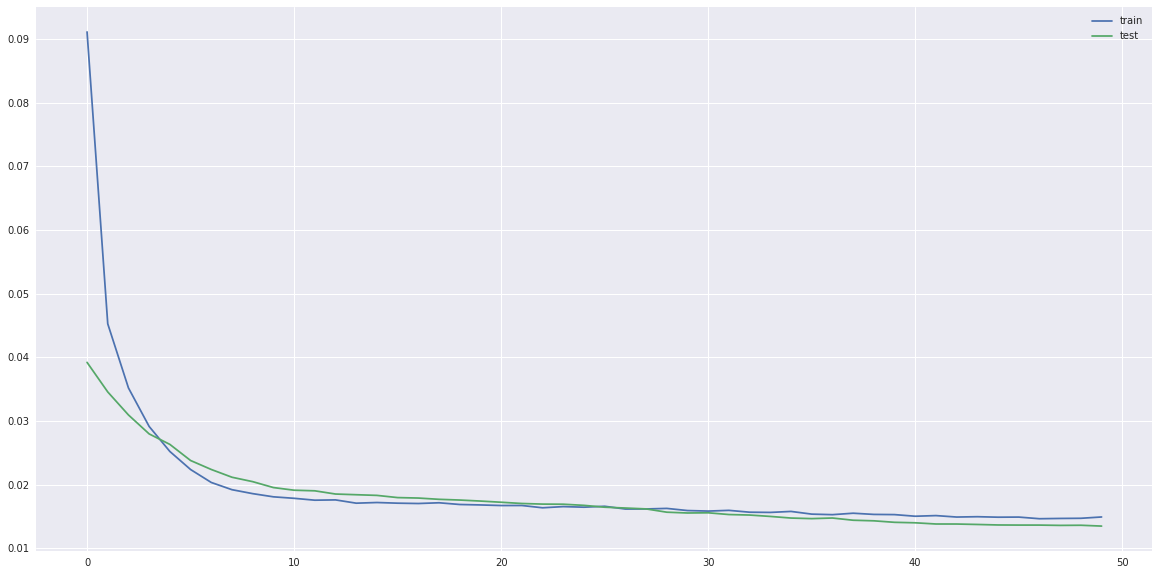

In [86]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [87]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

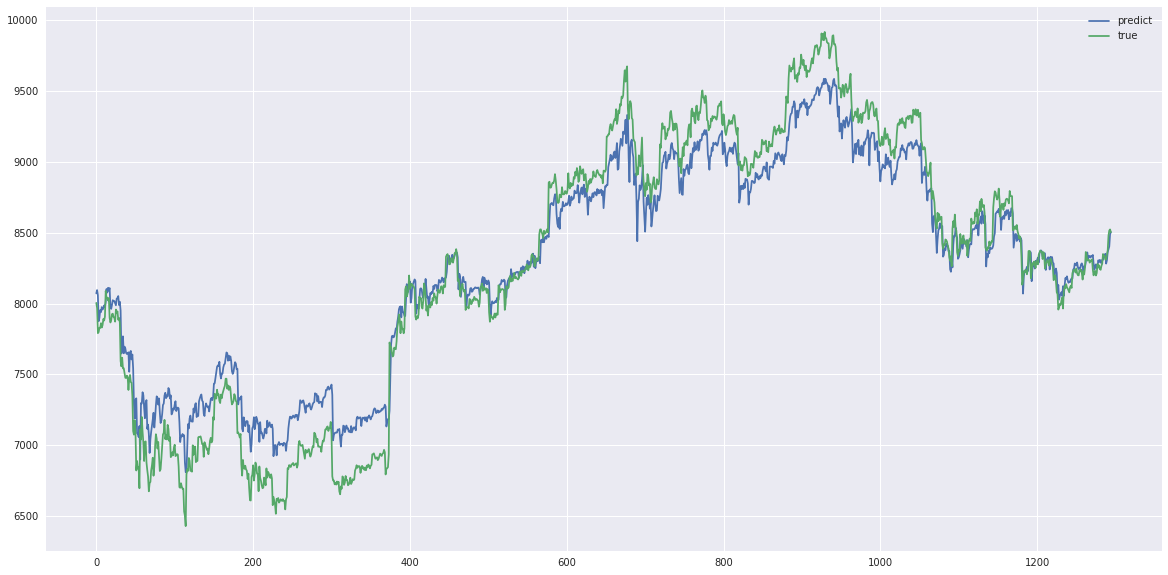

In [88]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20,10

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

In [89]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 219.537


In [90]:
inv_yhat[-3:]

array([8404.61614527, 8490.28540385, 8505.71126707])

In [91]:
inv_y[-3:]

array([8516.36, 8524.  , 8504.  ])

In [73]:
#Tranform the date field

data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05',
               '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09',
               '2018-05-10', '2018-05-11'],
              dtype='datetime64[ns]', name='Date', length=1009, freq=None)


,Close,Volume,Market Cap,ETH
Date,,,,
2015-08-07,279.59,42484800,4.032820e+09,2.770000
2015-08-08,261.00,58533000,4.048270e+09,0.753325
2015-08-09,265.08,23789600,3.779770e+09,0.701897
2015-08-10,264.47,20979400,3.843850e+09,0.708448
2015-08-11,270.39,25433900,3.828500e+09,1.070000


In [74]:
# load dataset
dataset1 = data[['ETH','Volume','Market Cap','Close']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.001984   0.001782   0.012371   0.014340  0.000539
2   0.000539   0.002455   0.012418   0.013386  0.000503
3   0.000503   0.000998   0.011594   0.013596  0.000507
4   0.000507   0.000880   0.011791   0.013564  0.000766
5   0.000766   0.001067   0.011744   0.013868  0.000874


In [75]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.5)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(504, 1, 4) (504,) (504, 1, 4) (504,)


Train on 504 samples, validate on 504 samples
Epoch 1/50
 - 1s - loss: 0.0013 - val_loss: 0.2548
Epoch 2/50
 - 0s - loss: 0.0021 - val_loss: 0.2539
Epoch 3/50
 - 0s - loss: 0.0022 - val_loss: 0.2552
Epoch 4/50
 - 0s - loss: 0.0021 - val_loss: 0.2554
Epoch 5/50
 - 0s - loss: 0.0021 - val_loss: 0.2555
Epoch 6/50
 - 0s - loss: 0.0020 - val_loss: 0.2549
Epoch 7/50
 - 0s - loss: 0.0020 - val_loss: 0.2553
Epoch 8/50
 - 0s - loss: 0.0020 - val_loss: 0.2566
Epoch 9/50
 - 0s - loss: 0.0018 - val_loss: 0.2558
Epoch 10/50
 - 0s - loss: 0.0025 - val_loss: 0.2529
Epoch 11/50
 - 0s - loss: 0.0024 - val_loss: 0.2520
Epoch 12/50
 - 0s - loss: 0.0025 - val_loss: 0.2521
Epoch 13/50
 - 0s - loss: 0.0020 - val_loss: 0.2517
Epoch 14/50
 - 0s - loss: 0.0021 - val_loss: 0.2513
Epoch 15/50
 - 0s - loss: 0.0020 - val_loss: 0.2519
Epoch 16/50
 - 0s - loss: 0.0021 - val_loss: 0.2512
Epoch 17/50
 - 0s - loss: 0.0022 - val_loss: 0.2530
Epoch 18/50
 - 0s - loss: 0.0019 - val_loss: 0.2534
Epoch 19/50
 - 0s - loss: 0

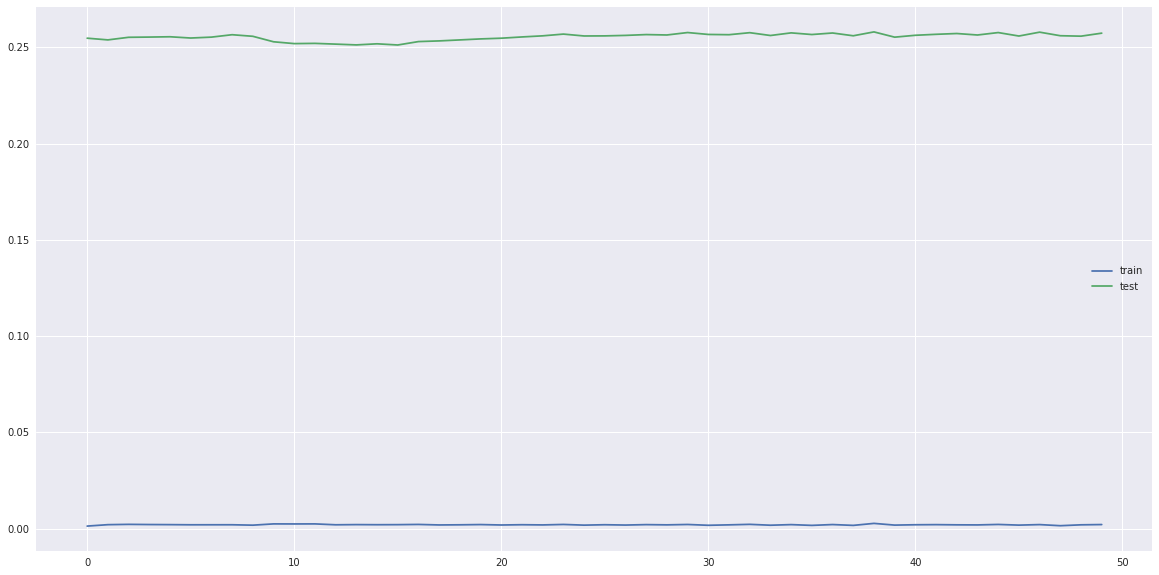

In [76]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=9, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [77]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

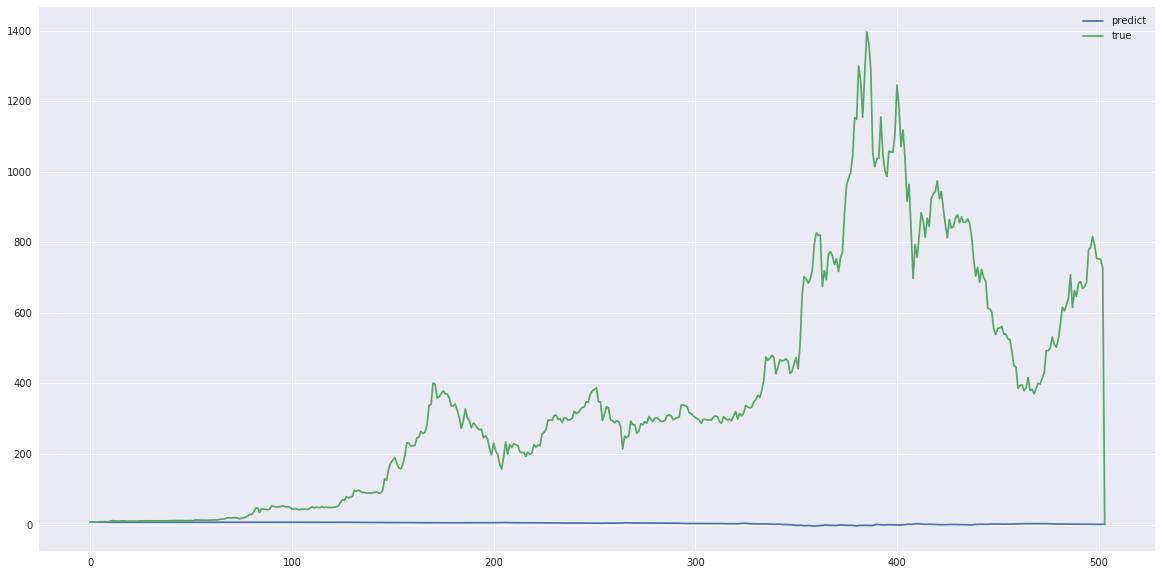

In [78]:

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

In [79]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 482.515


In [81]:
inv_yhat

array([ 6.88751061,  6.86615481,  6.87451584,  6.86894507,  6.86006579,
        6.84191642,  6.82609627,  6.83056225,  6.82512413,  6.81532343,
        6.80268696,  6.78178114,  6.7455045 ,  6.7828157 ,  6.85234071,
        6.87662072,  6.86217263,  6.86215702,  6.86069199,  6.9279593 ,
        6.94868045,  6.92800287,  6.91677745,  6.91506077,  6.91177956,
        6.88573865,  6.8771923 ,  6.8671432 ,  6.8636097 ,  6.85598866,
        6.8477746 ,  6.84390816,  6.86289506,  6.86608263,  6.85785686,
        6.85173272,  6.84519632,  6.84466636,  6.84635638,  6.8349671 ,
        6.81162671,  6.79672408,  6.78816993,  6.77243302,  6.77095693,
        6.77103041,  6.76172066,  6.7598206 ,  6.80502334,  6.80697736,
        6.79457108,  6.78883124,  6.79673904,  6.79419393,  6.78437957,
        6.77944281,  6.7684814 ,  6.75472647,  6.75356186,  6.74672959,
        6.73107656,  6.71498916,  6.69972954,  6.69387981,  6.68711842,
        6.68299123,  6.67151806,  6.67075596,  6.65647108,  6.64